# BHB formation channels with gaussian mixtures

1. **Load this file (np.load) and complete a quick exploration of the data. How many modes do you think you see?**

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks")
from Utilities import plot_settings

In [39]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\Notebooks\Data\formationchannels.npy", 'r')

Text(0, 0.5, 'Data value')

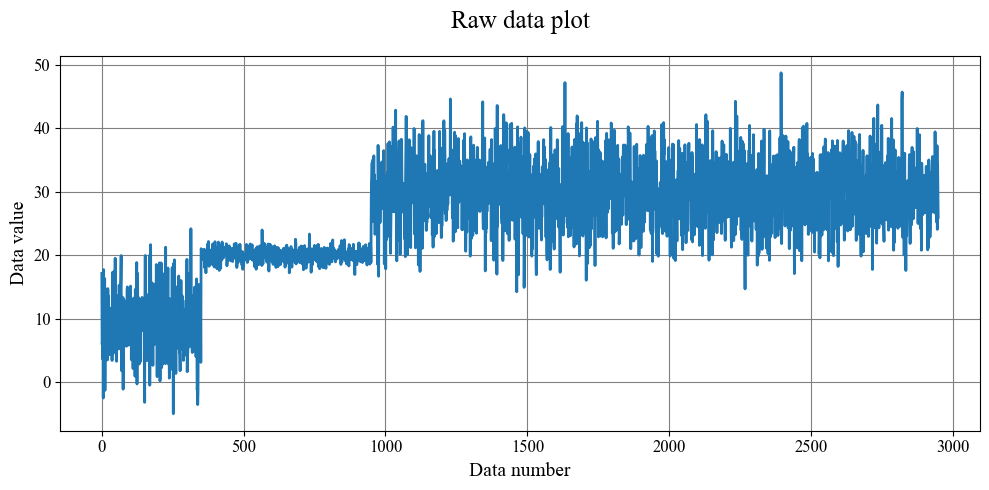

In [40]:
plt.plot(data.T[0])
plt.title('Raw data plot')
plt.xlabel('Data number')
plt.ylabel('Data value')

Probably this can be called out as cheating, but it is cristal clear from the upper plot that data vary around a mean value of 10 with a big sigma, then around 20 with a small sigma, then around 30 with a bigger sigma. I expect the algorithm to return 3 as the best number of modes. Let's pretend not to have seen this.

Text(0, 0.5, 'Frequencies')

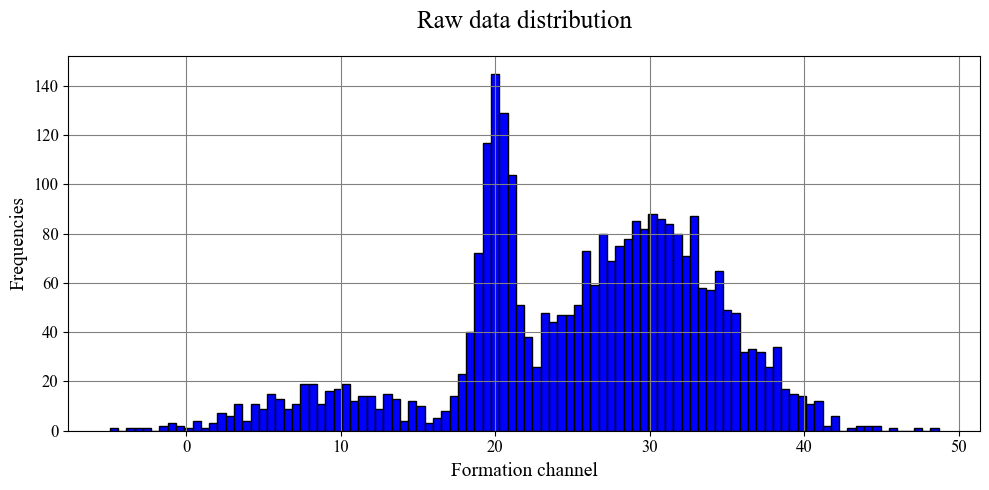

In [41]:
c, b ,_ = plt.hist(data, bins=100, density=False, histtype='barstacked', color='blue', edgecolor='black')
plt.title('Raw data distribution')
plt.xlabel('Formation channel')
plt.ylabel('Frequencies')

We can see clearly 3 peaks... Let's dive into a more quantitative approach

2. **We'll use sklearn.mixture.GaussianMixture. You first need to define the model (instance of a class), and then train it on the data using the fit method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.**
3. **Complete the fit 10 times with many Gaussians.**

In [42]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

Separate data for training the GaussianMixture class instance and testing it

In [50]:
train, temp = train_test_split(data, test_size=0.4, shuffle=True, random_state=42)
test, cv_data = train_test_split(temp, test_size=0.5, shuffle=True, random_state=42)

We'd like to see what happens changing the number of gaussians changes from 0 to 10

In [51]:
Ns = np.linspace(2,10,8, dtype=int)

In [52]:
x_plot = np.linspace(min(data.T[0]), max(data.T[0]), 1000)

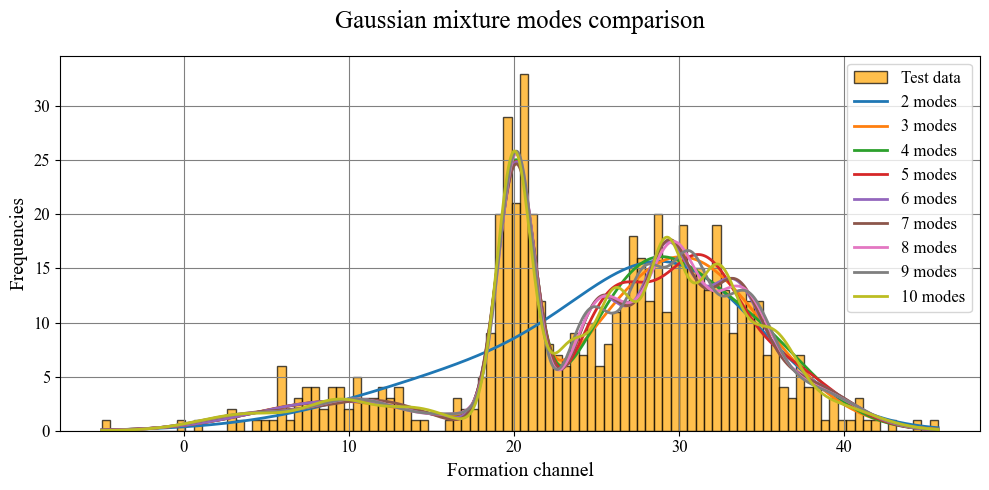

In [55]:
from sklearn.model_selection import KFold

Ns = [2, 3, 4, 5, 6, 7, 8, 9, 10]  # Number of components to test
AICs_train = []
AICs_cv = []

# Histogram on test data for visual reference
c2, b2, _ = plt.hist(
    test, bins=100, density=False, histtype='barstacked',
    color='orange', alpha=0.7, edgecolor='black', label='Test data'
)
bin_centers2 = 0.5 * (b2[:-1] + b2[1:])
x_plot = np.linspace(test.min(), test.max(), 1000)

# Loop over number of components
for n in Ns:
    # --- Train model on full train set ---
    Gauss = GaussianMixture(n_components=n, random_state=42)
    Gauss.fit(train)
    AICs_train.append(Gauss.aic(train))  # AIC on full train set

    # --- Cross-validated AIC ---
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    aic_folds = []

    for train_index, val_index in kf.split(cv_data):
        X_train_cv, X_val_cv = cv_data[train_index], cv_data[val_index]
        model_cv = GaussianMixture(n_components=n, random_state=42)
        model_cv.fit(X_train_cv)
        aic_folds.append(model_cv.aic(X_val_cv))

    AICs_cv.append(np.mean(aic_folds))  # Average AIC across folds

    # --- Plot model fitted on full train set ---
    plt.plot(
        x_plot,
        np.exp(Gauss.score_samples(x_plot.reshape(-1, 1))) * c2.sum() * (b2[1] - b2[0]),
        linewidth=2,
        label=f'{n} modes'
    )

plt.title('Gaussian mixture modes comparison')
plt.xlabel('Formation channel')
plt.ylabel('Frequencies')
plt.legend()

4. **For each of this fits, compute the AIC (easy! It's an attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?**

AIC $= -2\ln(L^{0}(M)) + 2k+ \frac{2k(k+1)}{N-k-1} \to$  the lesser the better

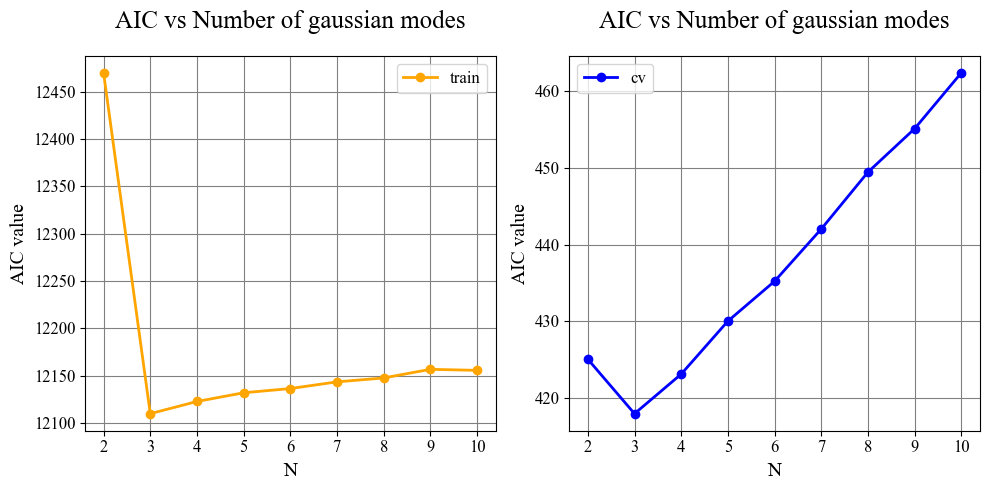

In [56]:
plt.subplot(1, 2, 1)
plt.plot(Ns, AICs_train, marker='o', color='orange', label='train')
plt.xlabel('N')
plt.ylabel('AIC value')
plt.title('AIC vs Number of gaussian modes')
plt.xticks(Ns)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Ns, AICs_cv, marker='o', color='blue', label='cv')
plt.xlabel('N')
plt.ylabel('AIC value')
plt.title('AIC vs Number of gaussian modes')
plt.xticks(Ns)
plt.legend()

The AIC statistic reaches a minimum at N=3. This will be our best model.

In [62]:
Gauss = GaussianMixture(n_components=3)

In [63]:
Gauss.fit(train.reshape(-1,1))

,n_components,3
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,None


In [66]:
print(f'Test set AIC : {Gauss.aic(test):.2f}')

Test set AIC : 3997.80


5. Plot the preferred solution on top of the input data. You should get a very nice fit!

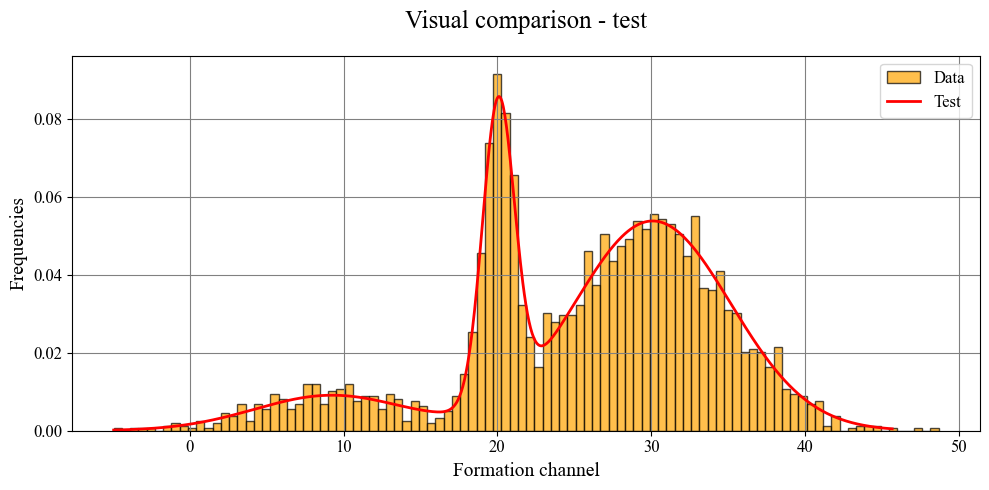

In [67]:
c3, b3,_ = plt.hist(data, bins=100, density=True, histtype='barstacked', color='orange', alpha=0.7, edgecolor='black', label='Data')
plt.plot(x_plot, np.exp(Gauss.score_samples(x_plot.reshape(-1,1))), linewidth=2, color='red', label='Test')
plt.title('Visual comparison - test')
plt.xlabel('Formation channel')
plt.ylabel('Frequencies')
plt.legend()

6. **Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset.
Hint: Useful methods here are score_samples and predict_proba**

In [68]:
from scipy.stats import norm

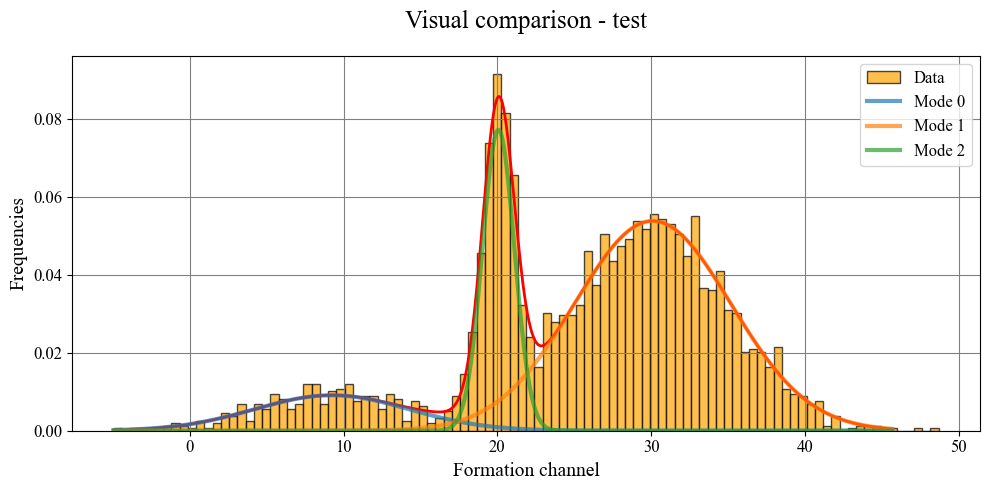

In [69]:
c3, b3,_ = plt.hist(data, bins=100, density=True, histtype='barstacked', color='orange', alpha=0.7, edgecolor='black', label='Data')
plt.plot(x_plot, np.exp(Gauss.score_samples(x_plot.reshape(-1,1))), linewidth=2, color='red')
for i in range(Gauss.n_components):
    plt.plot(x_plot, Gauss.weights_[i]*norm(loc=Gauss.means_[i], scale=np.sqrt(Gauss.covariances_[i])).pdf(x_plot)[0], 
             lw=3, label=f'Mode {i}', alpha=0.7)
plt.title('Visual comparison - test')
plt.xlabel('Formation channel')
plt.ylabel('Frequencies')
plt.legend()

This refers to maximization-expectation algorithm. Instead of solving a system containing $3M-1$ linear equations to determine all the triplets $\alpha_j, \mu_j, \sigma_j$ one can label a datum where the label corresponds to one of the modes that governs the given data set. Each class probability is given by Bayes theorem:

$p(j|x_i) = \frac{p(j) p_j(x_i|\theta)}{\sum_{j=1}^{M}p(j)(x_i|\theta)} = \frac{\alpha_j \mathcal{N}(\mu_j,\sigma_j)}{\sum_{j=1}^{M}\alpha_j \mathcal{N}(\mu_j,\sigma_j)}$

In [70]:
labels = Gauss.predict(data)

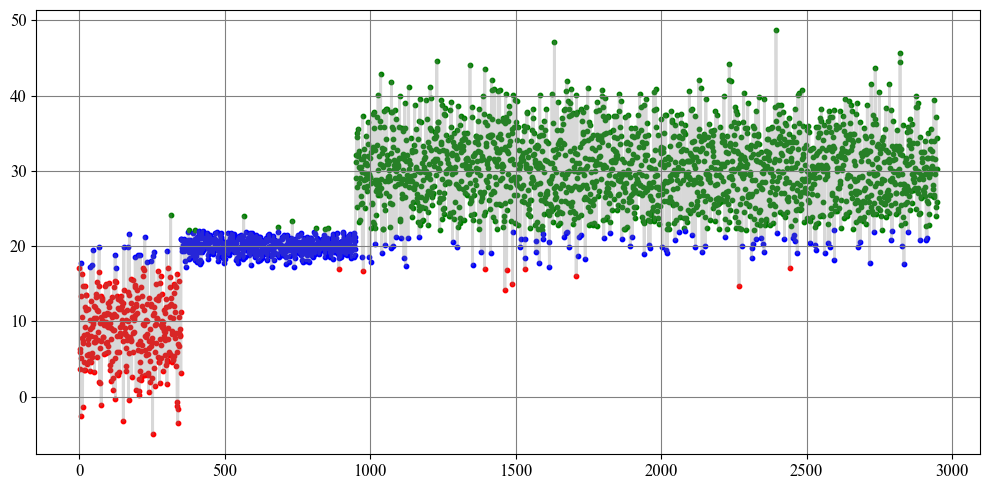

In [26]:
# Color map (fixed order: label 0 → red, 1 → blue, 2 → green)
colors = ['red', 'blue', 'green']

# Plot the full data as a semi-transparent line
plt.plot(data, color='gray', alpha=0.3, label='Raw data')

# Overlay each point with its component color
for i, (datum, label) in enumerate(zip(data.T[0], labels)):
    plt.scatter(i, datum, color=colors[label], s=10)